<a href="https://colab.research.google.com/github/yo-carthy/imageclassifier_leaves/blob/master/imageclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Install tensorflow

In [0]:
!pip install --upgrade "tensorflow==1.7.*"
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

     |████████████████████████████████| 48.1MB 199kB/s 
     |████████████████████████████████| 3.1MB 30.8MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107221 sha256=926d4248245628e3bf2b435eff7ce3dad49586b298d57d6481888eee84d03df5
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.7.1 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

#### Download tensorflow for poets model

In [0]:
%cd /content
!git clone https://github.com/googlecodelabs/tensorflow-for-poets-2
%cd tensorflow-for-poets-2

/content
Cloning into 'tensorflow-for-poets-2'...
remote: Enumerating objects: 426, done.
remote: Total 426 (delta 0), reused 0 (delta 0), pack-reused 426
Receiving objects: 100% (426/426), 33.97 MiB | 32.27 MiB/s, done.
Resolving deltas: 100% (159/159), done.
/content/tensorflow-for-poets-2


#### Extract dataset of healthy and sick crop images + .csv file

In [0]:
#AFTER RUNNING THIS, CREATE FORLDER CALLED MAIZE IMAGES AND MOVE ALL IMAGE FOLDERS INTO IT
%cd /content

fileId = "1wjce5HC2RvVXEY8I-DNMY-uEsmPoNyRL"

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)



/content


#### Change all file extensions to .jpg

In [0]:
import glob, os
folder = '/content/training_images'
for filename in glob.iglob(os.path.join(folder, '*.JPG')):
    os.rename(filename, filename[:-4] + '.jpg')

#### Create .txt files for train and test data

In [0]:
%cd /content/training_images
!ls -LR *.jpg > /content/images.txt

/content/training_images


#### Upload the .csv file

In [0]:
#BEFORE RUNNING THIS CREATE .CSV FILES AND UPLOAD THEM TO DRIVE
%cd /content

drive = GoogleDrive(gauth)
your_module = drive.CreateFile({"id": '1juWb2PZYCH8RY7JdiNzupz6HhDrefHB-'})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("maize_image_labels.csv")          # Save the .csv module file to Colab VM
                               #Ready to import. Don't include".py" part

print('Downloaded file ')

/content
Downloaded file 


#### Read the first 5 rows of .csv file

In [0]:
%cd /content
train=pd.read_csv('maize_image_labels.csv')    # reading the csv file
train.head()      # printing first five rows of the file

# train.columns

/content


,image,label_name,healthy,sick
0,healthy (1000).jpg,healthy,1,0
1,healthy (1001).jpg,healthy,1,0
2,healthy (1002).jpg,healthy,1,0
3,healthy (1003).jpg,healthy,1,0
4,healthy (1004).jpg,healthy,1,0


#### Loading and preprocessing the data - read in all the training images

In [0]:
%cd /content
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('training_images/'+train['image'][i],target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

/content


100%|██████████| 2354/2354 [00:06<00:00, 345.85it/s]


In [0]:
X.shape

(2354, 400, 400, 3)

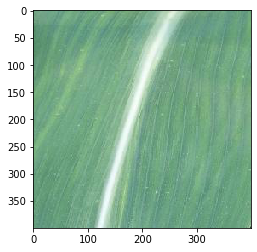

In [0]:
plt.imshow(X[2])

In [0]:
train['label_name'][2]

'healthy'

#### Drop Name column

In [0]:
y = np.array(train.drop(['image','label_name'],axis=1))
y.shape

(2354, 2)

#### Split 10% training data into validation /test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

#### CNN Architecture

In [0]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 93, 93, 64)       

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Train the data

##### train the model for 10 epochs and also pass the validation data which we created earlier in order to validate the model’s performance

In [0]:
model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test), batch_size=64)

Train on 2118 samples, validate on 236 samples
Epoch 1/2
2118/2118 [==============================] - 670s 316ms/step - loss: 0.4797 - acc: 0.7306 - val_loss: 0.0473 - val_acc: 0.9958
Epoch 2/2
2118/2118 [==============================] - 669s 316ms/step - loss: 0.0607 - acc: 0.9854 - val_loss: 0.0959 - val_acc: 0.9915


#### Make predictions

In [0]:
img = image.load_img('test1.jpg',target_size=(400,400,3))
img = image.img_to_array(img)
img = img/255

healthy (0.737)
sick (0.279)


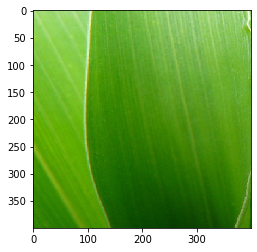

In [0]:
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,400,400,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(2):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)